# Note

This notebook is provided as an example, it needs to be adapted to work with non-custom models (`"clip-vit-l-336px-aligned"` is not available on timm)

# Prepare output heads

In [1]:
import os
import torch
from notebook_utils import prepare_backbone, prepare_output_head

print(torch.cuda.get_device_name(0))  # Results may vary slightly across GPUs, we train on NVIDIA H100 80GB HBM3.

NVIDIA H100 80GB HBM3


In [2]:
backbone_name = "clip-vit-l-336px"
backbone_aligned_name = "clip-vit-l-336px-aligned"

In [3]:
# Train script must be run from parent directory.
%cd -q ..

In [4]:
# Get output head for original model.
if os.path.exists(f"saved_models/{backbone_name}-coco-union-transformer.pth"):
    # Get backbone.
    print("Trained output head exists, loading instead of training")
    orig_backbone, orig_data_config = prepare_backbone(backbone_name, "transformer", "union", 0)

    # Load output head.
    orig_output_head = prepare_output_head("transformer", orig_data_config, "union", None, 2, 183)
    checkpoint = torch.load(f"saved_models/{backbone_name}-coco-union-transformer.pth")
    orig_output_head.load_state_dict(checkpoint)

    # Move to GPU.
    orig_output_head = orig_output_head.cuda()
    orig_backbone = orig_backbone.cuda()

else:
    # Run train script.
    print("Saved output head does not exist, training")
    %run -t scripts/train.py --backbone {backbone_name} --no-save --log-every 1000

    orig_output_head = output_head
    orig_backbone = backbone
    orig_data_config = backbone_config

    # Save output head.
    os.makedirs("saved_models", exist_ok=True)
    torch.save(orig_output_head.state_dict(), f"saved_models/{backbone_name}-coco-union-transformer.pth")
    print("Saved trained output head")

Trained output head exists, loading instead of training


/nlp/scr/icovert/miniconda3/envs/images/lib/python3.10/site-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, ma

In [5]:
# Get output head for aligned model.
if os.path.exists(f"saved_models/{backbone_aligned_name}-coco-union-transformer.pth"):
    # Get backbone.
    print("Trained output head exists, loading instead of training")
    aligned_backbone, aligned_data_config = prepare_backbone(backbone_aligned_name, "transformer", "union", 0)

    # Load output head.
    aligned_output_head = prepare_output_head("transformer", aligned_data_config, "union", None, 2, 183)
    checkpoint = torch.load(f"saved_models/{backbone_aligned_name}-coco-union-transformer.pth")
    aligned_output_head.load_state_dict(checkpoint)

    # Move to GPU.
    aligned_output_head = aligned_output_head.cuda()
    aligned_backbone = aligned_backbone.cuda()

else:
    # Run train script.
    print("Saved output head does not exist, training")
    %run -t scripts/train.py --backbone {backbone_aligned_name} --no-save --log-every 1000

    aligned_output_head = output_head
    aligned_backbone = backbone
    aligned_data_config = backbone_config

    # Save output head.
    os.makedirs("saved_models", exist_ok=True)
    torch.save(aligned_output_head.state_dict(), f"saved_models/{backbone_aligned_name}-coco-union-transformer.pth")
    print("Saved trained output head")

Trained output head exists, loading instead of training


/juice5/scr5/icovert/image-sandbox/masked-distillation/masked_distillation/train_utils.py:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoi

# Evaluate models

In [6]:
import torch.nn as nn
from torch.utils.data import DataLoader

from patchseg.dataset import CocoPatchDataset
from patchseg.loss import SizeUnionMetricsHelper, UnionMetricsHelper

In [7]:
def evaluate(
    backbone: nn.Module,
    output_head: nn.Module,
    loader: DataLoader,
    metrics_helpers: list[nn.Module],
) -> None:
    # Setup.
    backbone.eval()
    output_head.eval()
    for mh in metrics_helpers:
        mh.reset()

    with torch.no_grad():
        for image, annotation in loader:
            image = image.cuda()
            annotation = annotation.cuda()
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                features = backbone(image)
                logits = output_head(features)
                for mh in metrics_helpers:
                    mh(logits, annotation)

In [8]:
# Get the mean and std of the images.
assert orig_data_config["image_mean"] == aligned_data_config["image_mean"]
assert orig_data_config["image_std"] == aligned_data_config["image_std"]
image_mean, image_std = orig_data_config["image_mean"], orig_data_config["image_std"]

# Get the image width.
assert orig_data_config["image_width"] == aligned_data_config["image_width"]
image_width = orig_data_config["image_width"]

# Get the patch size.
assert orig_data_config["patch_size"] == aligned_data_config["patch_size"]
assert orig_data_config["num_patches"] == aligned_data_config["num_patches"]
assert orig_data_config["num_patches"] ** 0.5 * orig_data_config["patch_size"] == image_width
patch_size = orig_data_config["patch_size"]

In [9]:
# Prepare dataset.
val_dataset = CocoPatchDataset(
    image_width=image_width,
    patch_size=patch_size,
    split="val",
    image_mean=image_mean,
    image_std=image_std,
    label_reduction="union",
)
val_loader = DataLoader(val_dataset, batch_size=32)

In [10]:
# Set up metrics helpers.
num_buckets = 10
orig_size_metrics_helper = SizeUnionMetricsHelper(num_buckets=num_buckets)
orig_union_metrics_helper = UnionMetricsHelper(num_classes=val_dataset.num_classes)
aligned_size_metrics_helper = SizeUnionMetricsHelper(num_buckets=num_buckets)
aligned_union_metrics_helper = UnionMetricsHelper(num_classes=val_dataset.num_classes)

# Evaluate models.
evaluate(orig_backbone, orig_output_head, val_loader, [orig_size_metrics_helper, orig_union_metrics_helper])
evaluate(aligned_backbone, aligned_output_head, val_loader, [aligned_size_metrics_helper, aligned_union_metrics_helper])

# Plot per-class metrics

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from patchseg.dataset import coco_index_to_class

In [12]:
# Get per-class recall.
orig_recall = orig_union_metrics_helper.compute_class_recall()
aligned_recall = aligned_union_metrics_helper.compute_class_recall()

assert orig_recall.shape == aligned_recall.shape
num_classes = torch.arange(orig_recall.shape[0])

# Some classes are not present in the validation dataset.
assert torch.all(torch.isnan(orig_recall) == torch.isnan(aligned_recall))
valid_classes = ~torch.isnan(orig_recall)

# Get things and stuff class indices.
things_idxs = np.array([idx for idx in np.arange(1, 92) if valid_classes[idx]])
stuff_idxs = np.array([idx for idx in np.arange(92, 183) if valid_classes[idx]])

# Get recall of things and stuff classes.
orig_recall_things = orig_recall[things_idxs].numpy()
aligned_recall_things = aligned_recall[things_idxs].numpy()

orig_recall_stuff = orig_recall[stuff_idxs].numpy()
aligned_recall_stuff = aligned_recall[stuff_idxs].numpy()

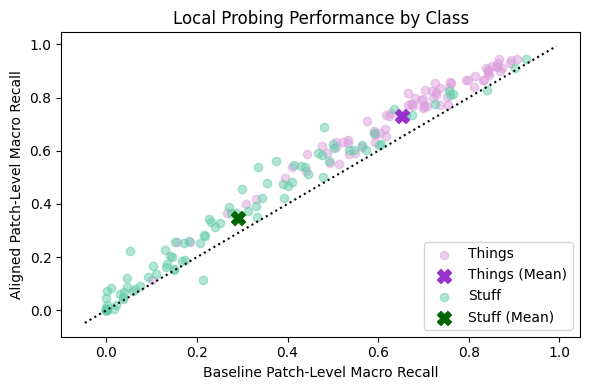

In [13]:
fig = plt.figure(figsize=(6, 4))

# Plot all points.
things = plt.scatter(orig_recall_things, aligned_recall_things, color="plum", label="Things", alpha=0.5)
stuff = plt.scatter(orig_recall_stuff, aligned_recall_stuff, color="mediumaquamarine", label="Stuff", alpha=0.5)
things_mean = plt.scatter(
    np.mean(orig_recall_things),
    np.mean(aligned_recall_things),
    marker="X",
    color="darkorchid",
    s=100,
    label="Things (Mean)",
)
stuff_mean = plt.scatter(
    np.mean(orig_recall_stuff),
    np.mean(aligned_recall_stuff),
    marker="X",
    color="darkgreen",
    s=100,
    label="Stuff (Mean)",
)

# Plot y = x line.
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
line_min = min(x_min, y_min)
line_max = max(x_max, y_max)
plt.plot([line_min, line_max], [line_min, line_max], linestyle=":", color="black")

plt.legend(loc="lower right", handles=[things, things_mean, stuff, stuff_mean])

plt.xlabel("Baseline Patch-Level Macro Recall")
plt.ylabel("Aligned Patch-Level Macro Recall")
plt.title("Local Probing Performance by Class")

plt.tight_layout()
plt.savefig("notebooks/figures/patchseg_stratified_class.pdf")
plt.show()

# Plot top per-class improvements

In [14]:
# Get classes with max recall difference for top n classes.
n = 10

things_diff = (aligned_recall_things - orig_recall_things).squeeze()
stuff_diff = (aligned_recall_stuff - orig_recall_stuff).squeeze()

things_diff_valid_idxs = np.argsort(things_diff)[::-1][:n]
things_diff_idxs = things_idxs[things_diff_valid_idxs]
things_diff_names = [coco_index_to_class[str(idx)] for idx in things_diff_idxs]

stuff_diff_valid_idxs = np.argsort(stuff_diff)[::-1][:n]
stuff_diff_idxs = stuff_idxs[stuff_diff_valid_idxs]
stuff_diff_names = [coco_index_to_class[str(idx)] for idx in stuff_diff_idxs]

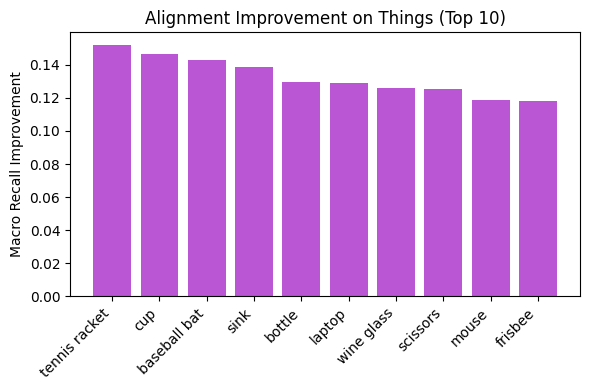

In [15]:
fig = plt.figure(figsize=(6, 4))

plt.bar(things_diff_names, things_diff[things_diff_valid_idxs], color="mediumorchid")

plt.xticks(ticks=range(n), rotation=45, ha="right")

plt.ylabel("Macro Recall Improvement")
plt.title(f"Alignment Improvement on Things (Top {n})")

plt.tight_layout()
plt.savefig("notebooks/figures/patchseg_improvement_things.pdf")
plt.show()

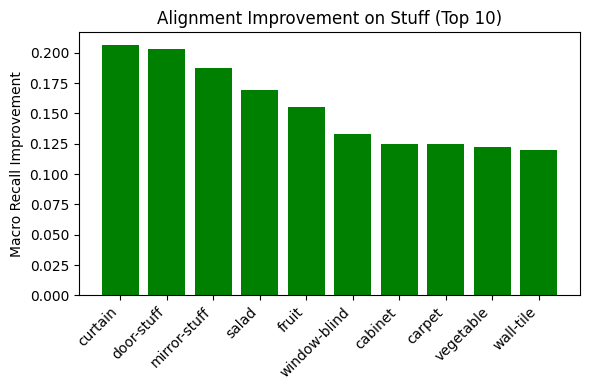

In [16]:
fig = plt.figure(figsize=(6, 4))

plt.bar(stuff_diff_names, stuff_diff[stuff_diff_valid_idxs], color="green")

plt.xticks(ticks=range(n), rotation=45, ha="right")

plt.ylabel("Macro Recall Improvement")
plt.title(f"Alignment Improvement on Stuff (Top {n})")

plt.tight_layout()
plt.savefig("notebooks/figures/patchseg_improvement_stuff.pdf")
plt.show()

# Plot improvement by object size

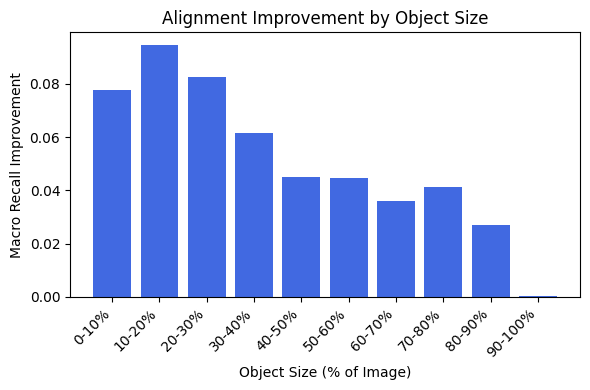

In [17]:
orig_size_recall = orig_size_metrics_helper.compute_class_recall()
aligned_size_recall = aligned_size_metrics_helper.compute_class_recall()

size_diff = (aligned_size_recall - orig_size_recall).numpy()

fig = plt.figure(figsize=(6, 4))

assert 100 % num_buckets == 0
step_size = 100 // num_buckets
buckets = [f"{i}-{i+step_size}%" for i in range(0, 100, step_size)]
plt.bar(buckets, size_diff, color="royalblue")

plt.xticks(ticks=range(num_buckets), rotation=45, ha="right")

plt.xlabel("Object Size (% of Image)")
plt.ylabel("Macro Recall Improvement")
plt.title("Alignment Improvement by Object Size")

plt.tight_layout()
plt.savefig("notebooks/figures/patchseg_stratified_size.pdf")
plt.show()